# Metro Canary

#### Required Modules

In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pickle
matplotlib.pylab.rcParams['figure.figsize'] = (14.0, 8.0)

## Load/parse the data

#### Load in Tweets as a DataFrame

In [2]:
with open('tweets_unique092315.pkl','r') as f:
    tweets092315 = pickle.load(f)
with open('tweets_unique.pkl','r') as f:
    tweets = pickle.load(f)
with open('oldtweets.pkl','r') as f:
    oldtweets = pickle.load(f)

In [3]:
timestamp = tweets092315['created_at'].values
ts = [pd.Timestamp(t).tz_convert('US/Eastern') for t in timestamp]
tweets092315.index = ts

In [4]:
tweets092315 = tweets092315[['id','text']]

In [5]:
timestamp = tweets['created_at'].values
ts = [pd.Timestamp(t).tz_convert('US/Eastern') for t in timestamp]
tweets.index = ts

In [6]:
tweets = tweets[['id','text']]

In [7]:
tweets_unique = tweets092315.append(tweets.append(oldtweets))

In [8]:
tweets_unique = tweets_unique.drop_duplicates(subset='id')
tweets_unique = tweets_unique.sort('id')

#### Set time-binning for Tweets and incidents

In [9]:
start = pd.Timestamp('2015-07-11 14:45:00')
finish = pd.Timestamp('2015-09-21 23:45:00')
time_index = pd.date_range(start,finish,freq='5t')

#### Load in Metro Rail Service Reports (http://www.wmata.com/rail/service_reports/viewReportArchive.cfm) as a DataFrame

In [10]:
with open('incidents092115.pkl') as f:
    incidents = pickle.load(f)

In [11]:
incidents = incidents[str(start): str(finish)]
incidents['delay'] = incidents['delay'].replace(to_replace='', value=0)
incidents = incidents[incidents['delay'] >= 5]
incidents = incidents[incidents['cause'] != 'did not operate']
incidents['delay_start'] = incidents.index
incidents['delay_end'] = [incidents.index[i] + pd.DateOffset(minutes=int(incidents.delay[i])) for i in range(len(incidents))]

In [12]:
incidents_time_index = pd.date_range(start,finish,freq='1t')

In [13]:
incidents_yes_no = []
for i in range(len(incidents_time_index)):
    teststamp = incidents_time_index[i]
    incidents_yes_no.append(len(incidents[(incidents['delay_start'] <= teststamp) & (incidents['delay_end'] >= teststamp)]))

In [14]:
incident_dict = {'timestamp' : incidents_time_index, 'activeincidents' : incidents_yes_no}
incident_DF = pd.DataFrame(incident_dict)
incident_DF.index = incident_DF.timestamp

#### Define functions related to parsing Tweets and Service Reports

In [15]:
def grabTweetText(tS):
    tweetText = []
    if (len(tS) == 0):
        return ''
    else:
        tweetText = (tS.to_string(columns=['text'],index=False,header=False,index_names=False))
        return tweetText

def getIncidentInfo(iS):
    if np.sum(iS['activeincidents'] == 0):
        incidentInfo = 0.
    else:
        incidentInfo = 1.
    return incidentInfo

def tweets_by_category(tweet):
    # remove usernames, hyperlinks, numbers, etc.
    # tweets = re.sub('[@][A-Za-z0-9]+','', tweets)
    tweet = re.sub('http://[A-Za-z\.\/0-9]+','', tweet)
    tweet = re.sub('https://[A-Za-z\.\/0-9]+','', tweet)
    tweet = re.sub('[0-9]+', '', tweet)
    tweet = tweet.replace('\'','')                                                       
    words = tweet.lower().split()
    # define tallies - words related to delays, words related to metro stations or lines, and words related to
    # people tweeting to the various complaint clearinghouses.
    delay_words = ['delay','delays','residual','tracking','single', 'minute', 'minutes']
    line_words = ['red','orange','blue','silver','yellow','green','line','station','train']
    angry_twits_words = ['RT','@wmata','@unsuckdcmetro','@metrorailinfo', '@metrofailinfo', '@fixwmata']
    angry_twits_words += ['@dcmetrosucks','@fixmetro', '@drgridlock' '#wmata', '#unsuckdcmetro', '#fixwmata']
    delay_related_tweets = 0
    line_related_tweets = 0
    angry_twits_related_tweets = 0
    if any(word in delay_words for word in words):
        delay_related_tweets += 1 
    
    if any(word in line_words for word in words):
        line_related_tweets += 1 
    
    if any(word in angry_twits_words for word in words):
        angry_twits_related_tweets += 1 
        
    return [delay_related_tweets, line_related_tweets, angry_twits_related_tweets]

def categorizeTweets(tS):
    catSums = {'delay' : 0, 'line' : 0 , 'twit' : 0}
    for tweet in tS['text']:
        tweetSum = tweets_by_category(tweet)
        catSums['delay'] += tweetSum[0]
        catSums['line'] += tweetSum[1]
        catSums['twit'] += tweetSum[2]
    return catSums


#### Bin number of Tweets, number of incidents, the text content of Tweets, and pertinent information about incidents

In [16]:
numTweets = []
tweetText = []
numIncidents = []
incidentInfo = []
numDelayTweets = []
numLineTweets = []
numTwitTweets = []

In [17]:
for i in range(1,len(time_index)):
    tweetSlice = tweets_unique[str(time_index[i-1]):str(time_index[i])]
    incidentSlice = incident_DF[str(time_index[i-1]):str(time_index[i])]
    numTweets.append(len(tweetSlice))
    tweetText.append(grabTweetText(tweetSlice))
    numIncidents.append(np.sum(incidentSlice['activeincidents']))
    incidentInfo.append(getIncidentInfo(incidentSlice))
    categoryTweetHolder = categorizeTweets(tweetSlice)
    numDelayTweets.append(categoryTweetHolder['delay'])
    numLineTweets.append(categoryTweetHolder['line'])
    numTwitTweets.append(categoryTweetHolder['twit'])

#### Plot number of Tweets and incidents as a function of time

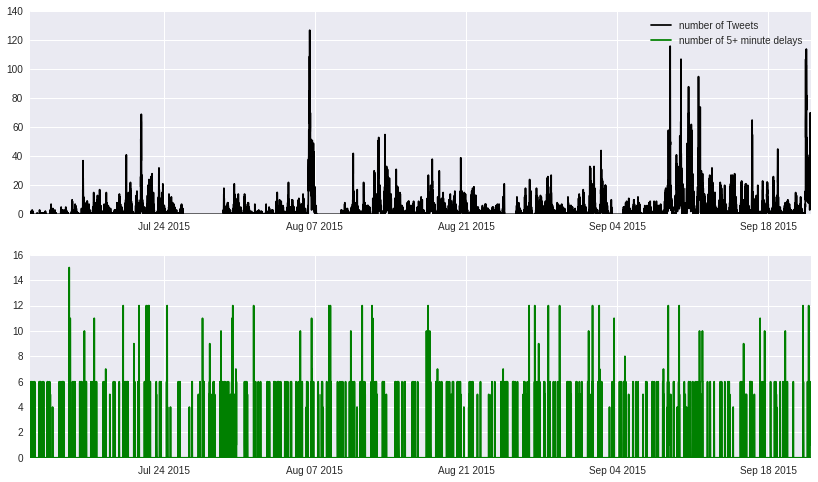

In [18]:
plt.subplot(211)
nT_plot, = plt.plot(time_index[1:len(time_index)],numTweets, color = 'k')
plt.subplot(212)
nI_plot, = plt.plot(time_index[1:len(time_index)],numIncidents, color ='g')
plt.subplot(211)
plt.legend([nT_plot, nI_plot], ['number of Tweets', 'number of 5+ minute delays'],loc='upper right')

#### Define targeted word searches (e.g. 'delay')

In [19]:
def tweets_word_frequency( tweets ):
    # remove usernames, hyperlinks, numbers, etc.
    # tweets = re.sub('[@][A-Za-z0-9]+','', tweets)
    tweets = re.sub('http://[A-Za-z\.\/0-9]+','', tweets)
    tweets = re.sub('https://[A-Za-z\.\/0-9]+','', tweets)
    tweets = re.sub('[0-9]+', '', tweets)
    tweets = tweets.replace('\'','')                          
    words = tweets.lower().split()                             
    # define tallies - words related to delays, words related to metro stations or lines, and words related to
    # people tweeting to the various complaint clearinghouses.
    delay_related_words = 0
    line_related_words = 0
    angry_twits_related_words = 0
    for word in words:
        if word in ['delay','delays','residual','tracking','single', 'late']:
            delay_related_words += 1
        elif word in ['red','orange','blue','silver','yellow','green','line','station','train']:
            line_related_words += 1
        elif word in ['RT','@wmata','@unsuckdcmetro','@metrorailinfo','@fixwmata','@dcmetrosucks','@fixmetro']:
            angry_twits_related_words += 1
        else:
            pass
    return delay_related_words, line_related_words, angry_twits_related_words

#### Then perform the search

In [20]:
DRW = []
LRW = []
ATRW = []
for tT in tweetText:
    drwnum, lrwnum, atrwnum = tweets_by_category(tT)
    DRW.append(drwnum)
    LRW.append(lrwnum)
    ATRW.append(atrwnum)

In [21]:
fracDelayTweets = [0] * len(numDelayTweets)
fracLineTweets = [0] * len(numDelayTweets)
fracTwitTweets = [0] * len(numDelayTweets)

for i in range(len(numDelayTweets)):
    totalTopicalTweets = float(numDelayTweets[i] + numLineTweets[i] + numTwitTweets[i])
    if(totalTopicalTweets != 0):
        fracDelayTweets[i] = float(numDelayTweets[i]) / totalTopicalTweets
        fracLineTweets[i] = float(numLineTweets[i]) / totalTopicalTweets
        fracTwitTweets[i] = float(numTwitTweets[i]) / totalTopicalTweets
    else:
        pass

In [22]:
training_DF = pd.DataFrame({'totalTweets' : numTweets, 'DRW' : DRW, 'LRW' : LRW, 'ATRW' : ATRW, 'NDT' : numDelayTweets, 'NLT' : numLineTweets, 'NTT' : numTwitTweets, 'FDT' : fracDelayTweets, 'FLT' : fracLineTweets, 'FTT' : fracTwitTweets, 'IncidentInfo' : incidentInfo})
training_DF.index = time_index[1:len(time_index)]
training_DF['hour'] = training_DF.index.hour
training_DF['dayofweek'] = training_DF.index.dayofweek
training_DF['cut'] = True
training_DF['cut']['2015-07-11 14:45:00' : '2015-07-14 11:00:00'] = False
training_DF['cut']['2015-07-25 19:15:00' : '2015-07-29 12:30:00'] = False
training_DF['cut']['2015-08-07 03:45:00' : '2015-08-09 10:15:00'] = False
training_DF['cut']['2015-08-24 14:40:00' : '2015-08-25 16:30:00'] = False
training_DF['cut']['2015-09-03 12:10:00' : '2015-09-06 13:40:00'] = False
training_DF = training_DF[training_DF['cut'] == True]

/opt/conda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

## A look at the training data

In [42]:
training_DF.drop(['IncidentInfo','ATRW','LRW','DRW','NLT','NTT','NDT','cut'],axis=1)['09-08-2015 10:00:00' : '09-08-2015 11:00:00']

,FDT,FLT,FTT,totalTweets,hour,dayofweek
2015-09-08 10:00:00,0.428571,0.428571,0.142857,4,10,1
2015-09-08 10:05:00,0.500000,0.500000,0.000000,3,10,1
2015-09-08 10:10:00,0.421053,0.421053,0.157895,9,10,1
2015-09-08 10:15:00,0.428571,0.428571,0.142857,5,10,1
2015-09-08 10:20:00,0.500000,0.250000,0.250000,2,10,1
2015-09-08 10:25:00,0.400000,0.400000,0.200000,3,10,1
2015-09-08 10:30:00,0.333333,0.333333,0.333333,2,10,1
2015-09-08 10:35:00,0.428571,0.428571,0.142857,4,10,1
2015-09-08 10:40:00,0.375000,0.250000,0.375000,4,10,1
2015-09-08 10:45:00,0.357143,0.357143,0.285714,8,10,1


In [23]:
plot_DF = training_DF['09-08-2015 09:00:00' : '09-09-2015 06:00:00']

In [24]:
plot_DF = plot_DF.drop(['NDT', 'NLT', 'NTT','ATRW','DRW', 'LRW', 'totalTweets', 'hour', 'dayofweek' ,'cut'],axis=1)

(0, 2)

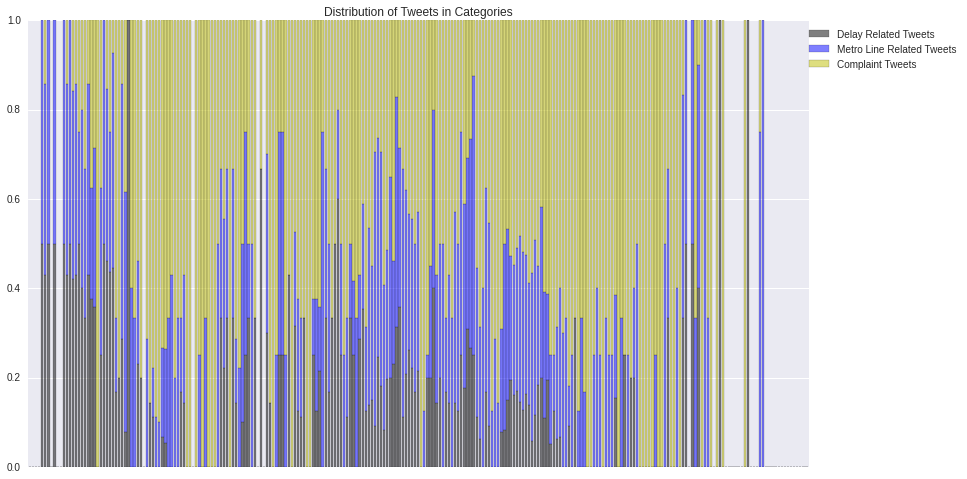

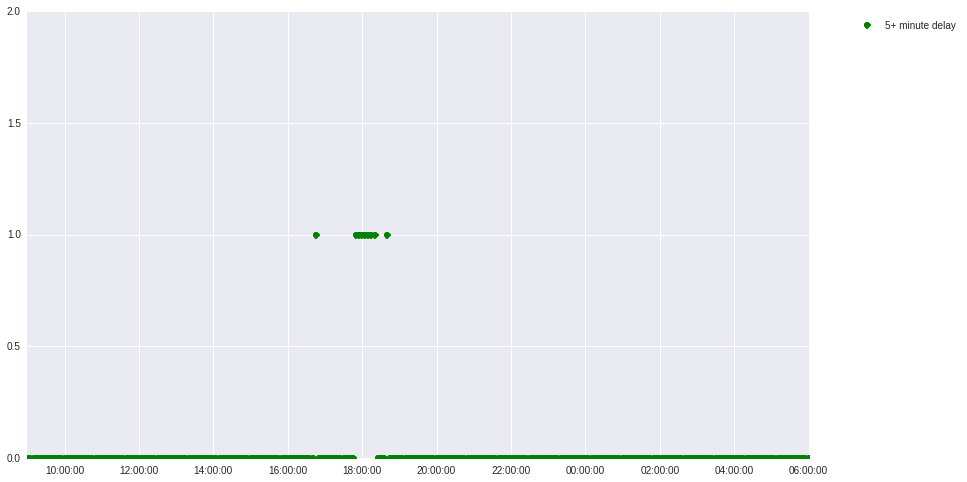

In [25]:
# Create the general blog and the "subplots" i.e. the bars
f, ax1 = plt.subplots(1)#, figsize=(14,8))
# Set the bar width
bar_width = 0.75

# positions of the left bar-boundaries
bar_l = [i+1 for i in range(len(plot_DF['FDT']))]

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l]

# Create a bar plot, in position bar_1
ax1.bar(bar_l,
        # using the pre_score data
        plot_DF['FDT'],
        # set the width
        width=bar_width,
        # with the label pre score
        label='Delay Related Tweets',
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='k')

# Create a bar plot, in position bar_1
ax1.bar(bar_l,
        # using the mid_score data
        plot_DF['FLT'],
        # set the width
        width=bar_width,
        # with pre_score on the bottom
        bottom=plot_DF['FDT'],
        # with the label mid score
        label='Metro Line Related Tweets',
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='b')

# Create a bar plot, in position bar_1
ax1.bar(bar_l,
        # using the post_score data
        plot_DF['FTT'],
        # set the width
        width=bar_width,
        # with pre_score and mid_score on the bottom
        bottom=[i+j for i,j in zip(plot_DF['FDT'],plot_DF['FLT'])],
        # with the label post score
        label='Complaint Tweets',
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='y')

# set the x ticks with names
plt.xticks(tick_pos, plot_DF.index)
ax1.get_xaxis().set_visible(False)
# Set the label and legends
ax1.set_ylabel("")
ax1.set_xlabel("")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.title('Distribution of Tweets in Categories')

# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.subplots(1)#, figsize=(14,8))
ii, = plt.plot(plot_DF.index,plot_DF.IncidentInfo,'o',color='g')
plt.legend([ii], ['5+ minute delay'], loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.ylim(0,2)

## Train a Random Forest classifier

In [26]:
print "Fraction of data containing delays: %.3f" % float(sum(training_DF['IncidentInfo'])/len(training_DF))

Fraction of data containing delays: 0.033


### We are confronted with the problem of rare events - this can be addressed through a class-weighted Random Forest:  http://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf

In [27]:
x_train_data = training_DF.drop(['IncidentInfo','ATRW','LRW','DRW','NLT','NTT','NDT','cut'],axis=1) # 
y_train_data = training_DF['IncidentInfo']

In [28]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train_data, y_train_data, test_size=0.1, random_state=1337)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
clf = RandomForestClassifier()
parameters = {'n_estimators' : [2**n for n in range(0,8)], 'class_weight' : [{0 : 1, 1 : 3**n} for n in range(0,8)]}
gscv = GridSearchCV(clf, parameters, scoring='f1')

In [30]:
gscv.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128], 'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3}, {0: 1, 1: 9}, {0: 1, 1: 27}, {0: 1, 1: 81}, {0: 1, 1: 243}, {0: 1, 1: 729}, {0: 1, 1: 2187}]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring='f1',
       verbose=0)

In [31]:
gscv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 27},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Make a prediction!

In [32]:
y_pred = gscv.best_estimator_.predict(x_test)

In [33]:
from sklearn import metrics
print 'predicted', sum(y_pred), 'actual', sum(y_test)
print "Accuracy:", metrics.accuracy_score(y_pred, y_test)
print "Precision:", metrics.precision_score(y_pred, y_test)
print "Recall:", metrics.recall_score(y_pred, y_test)
print "F1:", metrics.f1_score(y_pred, y_test)

predicted 314.0 actual 49.0
Accuracy: 0.808883693746
Precision: 0.367346938776
Recall: 0.0573248407643
F1: 0.099173553719


(0, 2)

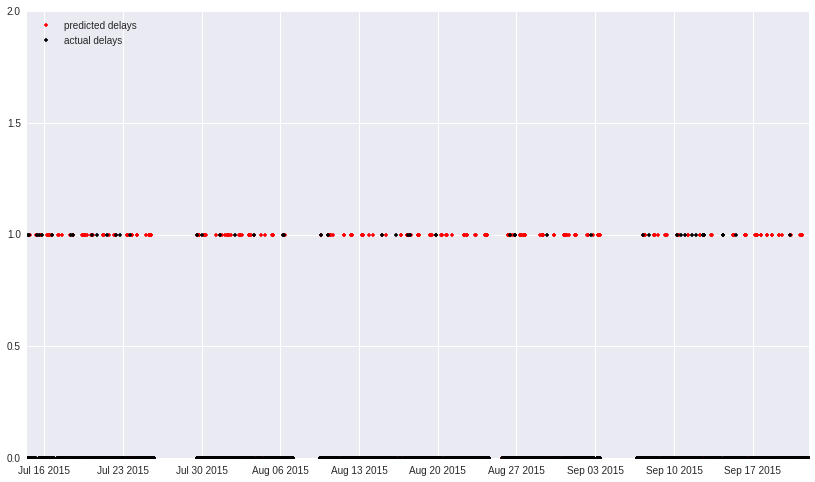

In [34]:
y_dict = {'pred' : y_pred, 'test' : y_test.values}
y_DF = pd.DataFrame(y_dict)
y_DF.index = y_test.index
time = y_DF.index.values
predicted = y_DF['pred'].values
actual = y_DF['test'].values
pred_plot, = plt.plot(time,predicted,'.',color='r')
act_plot, = plt.plot(time,actual,'.',color='k')
plt.legend([pred_plot, act_plot], ['predicted delays', 'actual delays'],loc='upper left')
plt.ylim(0,2)

## OK, which features seem to matter the most?

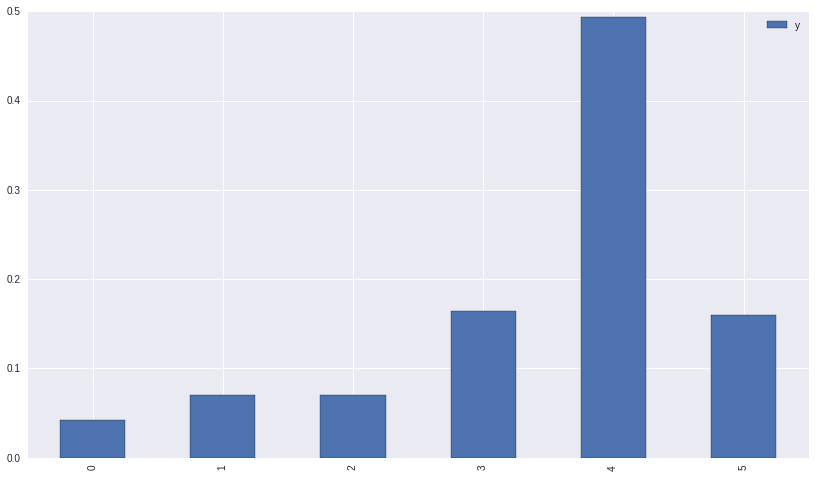

In [71]:
x_bar = x_train_data.columns.tolist()
y_bar = gscv.best_estimator_.feature_importances_
bar_dict = {'x' : x_bar , 'y' : y_bar}
bar_DF = pd.DataFrame(bar_dict)
bar_DF.plot(kind='bar')